In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alzheimer-features/alzheimer.csv


In [32]:
pip install xgboost


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [33]:
pip install imblearn


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [35]:
# Load dataset
df = pd.read_csv("/kaggle/input/alzheimer-features/alzheimer.csv")

# Display basic info
print(df.info())
print(df.describe())
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Group   373 non-null    object 
 1   M/F     373 non-null    object 
 2   Age     373 non-null    int64  
 3   EDUC    373 non-null    int64  
 4   SES     354 non-null    float64
 5   MMSE    371 non-null    float64
 6   CDR     373 non-null    float64
 7   eTIV    373 non-null    int64  
 8   nWBV    373 non-null    float64
 9   ASF     373 non-null    float64
dtypes: float64(5), int64(3), object(2)
memory usage: 29.3+ KB
None
              Age        EDUC         SES        MMSE         CDR  \
count  373.000000  373.000000  354.000000  371.000000  373.000000   
mean    77.013405   14.597855    2.460452   27.342318    0.290885   
std      7.640957    2.876339    1.134005    3.683244    0.374557   
min     60.000000    6.000000    1.000000    4.000000    0.000000   
25%     71.000000   12.000000    2.000

In [36]:
# Handle missing values with KNN Imputer
imputer = KNNImputer(n_neighbors=5)
df[['SES', 'MMSE']] = imputer.fit_transform(df[['SES', 'MMSE']])

# Create CDR_Class mapping
cdr_class_map = {
    0.0: 'Non Dementia(CN)',
    0.5: 'Very Mild Dementia(EMCI)',
    1.0: 'Mild Dementia(LMCI)',
    2.0: 'Moderate Dementia(AD)'
}
df['CDR_Class'] = df['CDR'].map(cdr_class_map).fillna('Moderate Dementia(AD)')

# Feature Engineering
df['Age_Group'] = (df['Age'] > 75).astype(int)  # Binarize Age
df['nWBV_eTIV'] = df['nWBV'] / df['eTIV']     # Interaction term

# Encode categorical variables
df['Group'] = LabelEncoder().fit_transform(df['Group'])  # Demented=1, Nondemented=0
df['M/F'] = LabelEncoder().fit_transform(df['M/F'])      # Male=1, Female=0
df['CDR_Class'] = LabelEncoder().fit_transform(df['CDR_Class'])

# Drop irrelevant columns
df = df.drop(columns=['CDR'])

In [37]:
# Features and targets
X = df.drop(columns=['Group', 'CDR_Class'])
y1 = df['Group']    # Target1: Group (Binary)
y2 = df['CDR_Class']  # Target2: CDR_Class (Multiclass)

# Train-test split
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(
    X, y1, y2, test_size=0.2, random_state=42, stratify=y2
)

In [38]:
print("Class distribution in y2_train:", np.bincount(y2_train))

Class distribution in y2_train: [ 33   2 165  98]


In [39]:
# Example: If the smallest class has 2 samples, set k_neighbors=1
smote = SMOTE(random_state=42, k_neighbors=1)
X_res, y2_res = smote.fit_resample(X_train, y2_train)

In [40]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scaled data for resampled Target2
X_res_scaled = scaler.transform(X_res)

In [41]:
# Define models with hyperparameter grids
models = {
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        "params": {
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1],
            'n_estimators': [100, 200]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            'n_estimators': [100, 200],
            'max_depth': [None, 5]
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {'C': [0.1, 1, 10]}
    },
    "SVM": {
        "model": SVC(),
        "params": {'C': [0.1, 1], 'kernel': ['linear', 'rbf']}
    },
    "Naive Bayes": {
        "model": GaussianNB(),
        "params": {}
    }
}

# Ensemble models
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
        ('rf', RandomForestClassifier()),
        ('lr', LogisticRegression(max_iter=1000))
    ],
    final_estimator=LogisticRegression()
)

voting_model = VotingClassifier(
    estimators=[
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
        ('rf', RandomForestClassifier()),
        ('nb', GaussianNB())
    ],
    voting='soft'
)

=== Target1: Group Prediction ===


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:48:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:48:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:48:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:48:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:48:36] WARNING: /w

XGBoost Accuracy: 85.33%
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.92      0.83      0.87        29
           2       0.80      0.95      0.87        38

    accuracy                           0.85        75
   macro avg       0.91      0.76      0.80        75
weighted avg       0.87      0.85      0.85        75



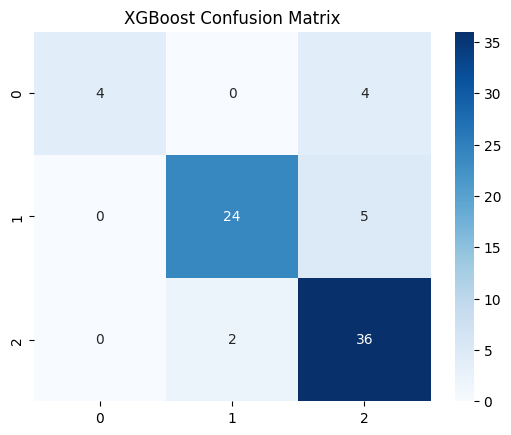

Random Forest Accuracy: 82.67%
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.89      0.83      0.86        29
           2       0.78      0.95      0.86        38

    accuracy                           0.83        75
   macro avg       0.89      0.67      0.70        75
weighted avg       0.85      0.83      0.81        75



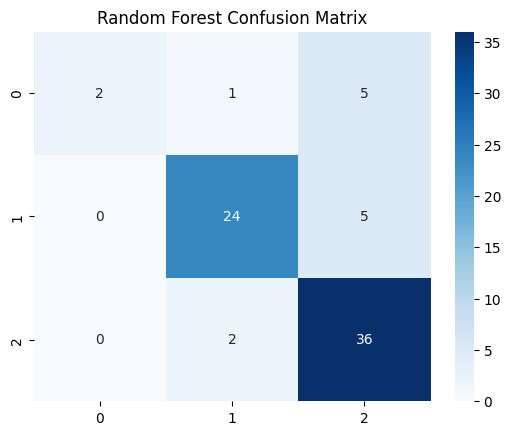

Logistic Regression Accuracy: 81.33%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.92      0.83      0.87        29
           2       0.77      0.97      0.86        38

    accuracy                           0.81        75
   macro avg       0.56      0.60      0.58        75
weighted avg       0.75      0.81      0.77        75



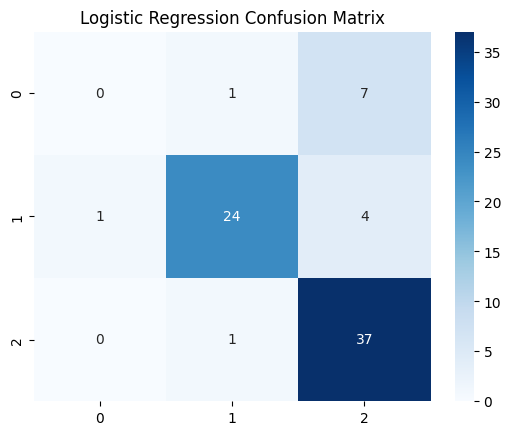

SVM Accuracy: 77.33%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.92      0.76      0.83        29
           2       0.77      0.95      0.85        38

    accuracy                           0.77        75
   macro avg       0.56      0.57      0.56        75
weighted avg       0.74      0.77      0.75        75



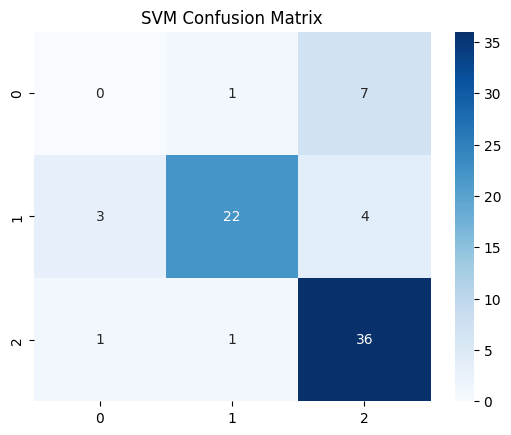

Naive Bayes Accuracy: 76.00%
              precision    recall  f1-score   support

           0       0.22      0.25      0.24         8
           1       0.95      0.72      0.82        29
           2       0.77      0.89      0.83        38

    accuracy                           0.76        75
   macro avg       0.65      0.62      0.63        75
weighted avg       0.78      0.76      0.76        75



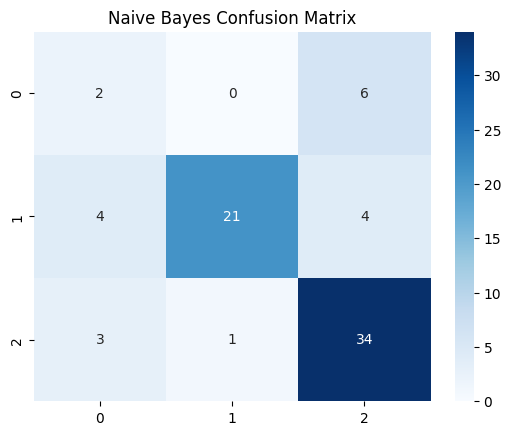

=== Target2: CDR_Class Prediction ===


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:49:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:49:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:49:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:49:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:49:03] WARNING: /w

XGBoost Accuracy: 73.33%


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.60      0.38      0.46         8
           1       0.00      0.00      0.00         1
           2       0.80      0.95      0.87        41
           3       0.62      0.52      0.57        25

    accuracy                           0.73        75
   macro avg       0.50      0.46      0.47        75
weighted avg       0.71      0.73      0.71        75



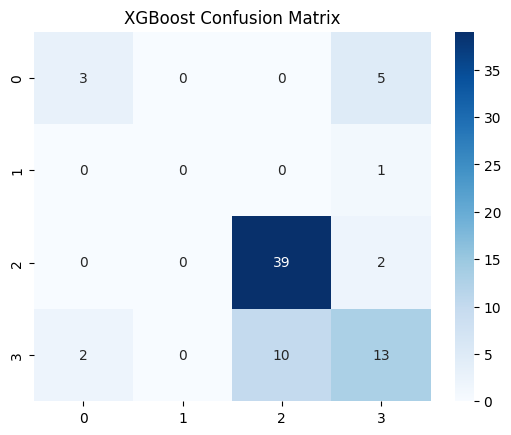

Random Forest Accuracy: 72.00%


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.67      0.25      0.36         8
           1       0.00      0.00      0.00         1
           2       0.79      0.93      0.85        41
           3       0.58      0.56      0.57        25

    accuracy                           0.72        75
   macro avg       0.51      0.43      0.45        75
weighted avg       0.70      0.72      0.70        75



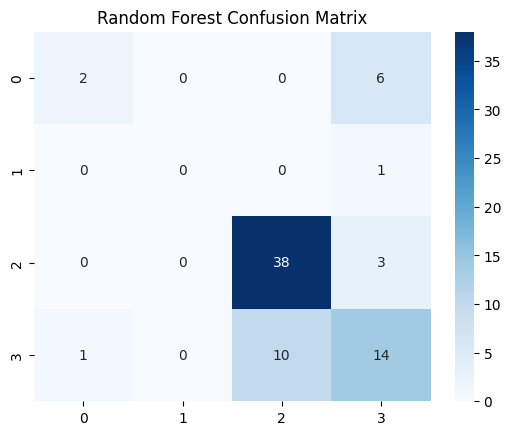

Logistic Regression Accuracy: 74.67%
              precision    recall  f1-score   support

           0       0.38      0.38      0.38         8
           1       0.00      0.00      0.00         1
           2       0.87      0.95      0.91        41
           3       0.70      0.56      0.62        25

    accuracy                           0.75        75
   macro avg       0.49      0.47      0.48        75
weighted avg       0.75      0.75      0.74        75



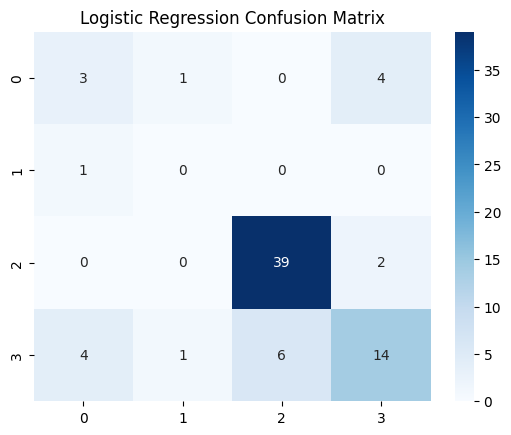

SVM Accuracy: 73.33%


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.50      0.25      0.33         8
           1       0.00      0.00      0.00         1
           2       0.81      0.93      0.86        41
           3       0.62      0.60      0.61        25

    accuracy                           0.73        75
   macro avg       0.48      0.44      0.45        75
weighted avg       0.70      0.73      0.71        75



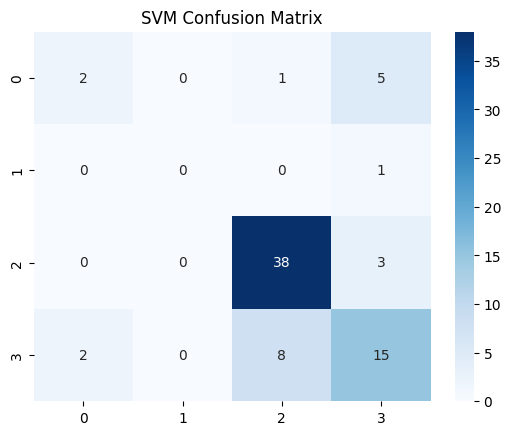

Naive Bayes Accuracy: 76.00%
              precision    recall  f1-score   support

           0       0.60      0.38      0.46         8
           1       0.00      0.00      0.00         1
           2       0.84      0.93      0.88        41
           3       0.70      0.64      0.67        25

    accuracy                           0.76        75
   macro avg       0.54      0.49      0.50        75
weighted avg       0.76      0.76      0.75        75



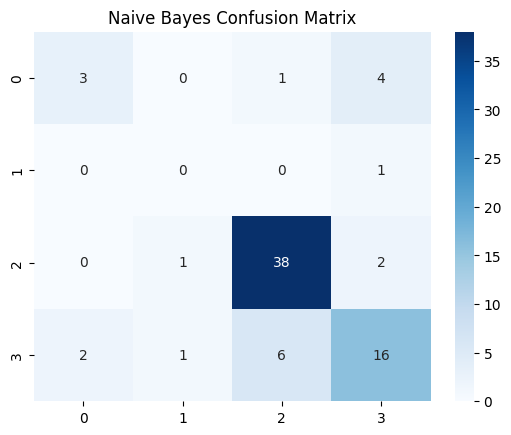

=== Ensemble Models for Target2 ===


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:49:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:49:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:49:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:49:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:49:40] WARNING: /w

Stacking Accuracy: 74.67%


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.00      0.00      0.00         1
           2       0.81      0.95      0.88        41
           3       0.62      0.64      0.63        25

    accuracy                           0.75        75
   macro avg       0.61      0.43      0.43        75
weighted avg       0.76      0.75      0.71        75



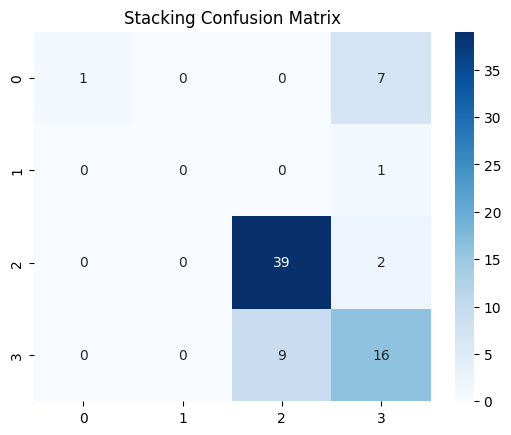

/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:49:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Voting Accuracy: 74.67%
              precision    recall  f1-score   support

           0       0.75      0.38      0.50         8
           1       0.00      0.00      0.00         1
           2       0.81      0.95      0.88        41
           3       0.64      0.56      0.60        25

    accuracy                           0.75        75
   macro avg       0.55      0.47      0.49        75
weighted avg       0.74      0.75      0.73        75



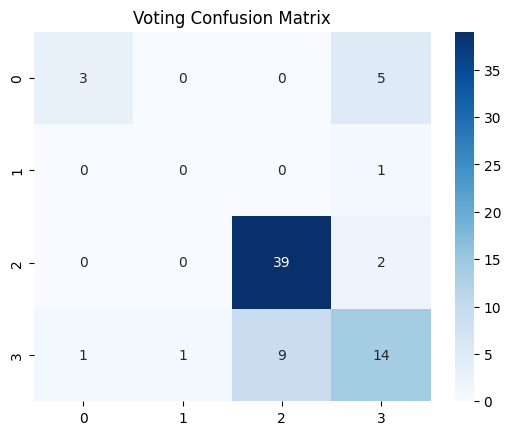

0.7466666666666667

In [42]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.2%}")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()
    return acc

# Results storage
results = {}

# Train on Target1 (Group)
print("=== Target1: Group Prediction ===")
for name, config in models.items():
    grid = GridSearchCV(config["model"], config["params"], cv=3, scoring='accuracy')
    results[name] = evaluate_model(grid, X_train_scaled, y1_train, X_test_scaled, y1_test, name)

# Train on Target2 (CDR_Class) with SMOTE
print("=== Target2: CDR_Class Prediction ===")
for name, config in models.items():
    grid = GridSearchCV(config["model"], config["params"], cv=3, scoring='accuracy')
    results[name] = evaluate_model(grid, X_res_scaled, y2_res, X_test_scaled, y2_test, name)

# Ensemble models for Target2
print("=== Ensemble Models for Target2 ===")
evaluate_model(stacking_model, X_res_scaled, y2_res, X_test_scaled, y2_test, "Stacking")
evaluate_model(voting_model, X_res_scaled, y2_res, X_test_scaled, y2_test, "Voting")

/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:49:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


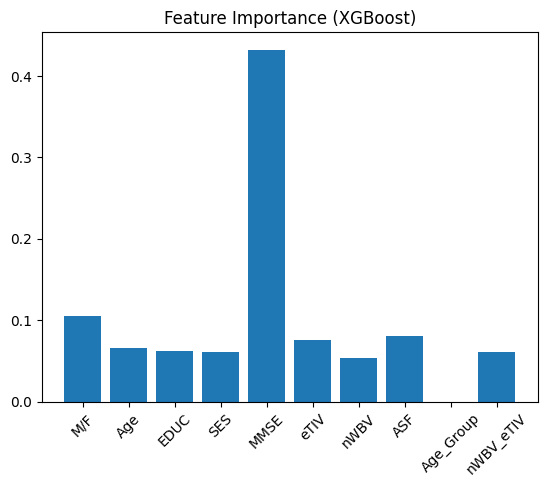

In [43]:
# Feature importance from XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y1_train)
importances = xgb.feature_importances_
plt.bar(X.columns, importances)
plt.title("Feature Importance (XGBoost)")
plt.xticks(rotation=45)
plt.show()

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:55:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:55:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:55:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:55:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:55:07] WARNING: /w

Best XGBoost Accuracy on Target1: 86.67%
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.93      0.86      0.89        29
           2       0.82      0.95      0.88        38

    accuracy                           0.87        75
   macro avg       0.91      0.77      0.81        75
weighted avg       0.88      0.87      0.86        75



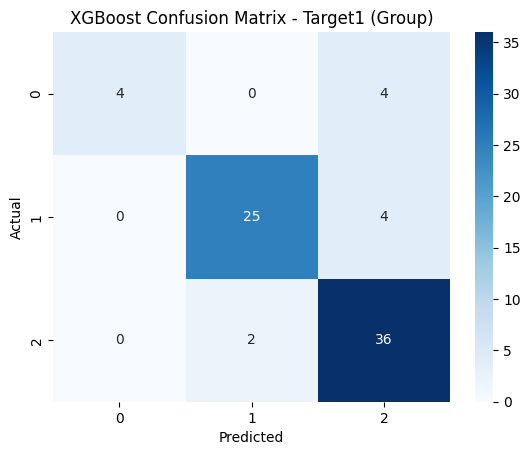

✅ Best XGBoost model saved as 'xgboost_target1_group.pkl'


In [48]:
import joblib

# Define the XGBoost model and parameter grid
xgb_params = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_params,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit on Target1
grid_search.fit(X_train, y1_train)

# Get best model from grid search
best_xgb = grid_search.best_estimator_

# Predict on test set
y_pred = best_xgb.predict(X_test)

# Evaluate performance
acc = accuracy_score(y1_test, y_pred)
print(f"Best XGBoost Accuracy on Target1: {acc:.2%}")
print("Best Parameters:", grid_search.best_params_)
print("Classification Report:")
print(classification_report(y1_test, y_pred))

# Confusion matrix visualization
cm = confusion_matrix(y1_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("XGBoost Confusion Matrix - Target1 (Group)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save the best XGBoost model
joblib.dump(best_xgb, 'xgboost_target1_group.pkl')
print("✅ Best XGBoost model saved as 'xgboost_target1_group.pkl'")

In [49]:
import joblib
xgb_model = joblib.load("xgboost_target1_group.pkl")
print("Classes seen during training:", xgb_model.classes_)

Classes seen during training: [0 1 2]
